Here is a hodgepodge of Astropy capabilities...

# Astropy

## Tables

Astropy also has tables, and the functionality has some similarities and differences from the Pandas tables.  The real power in using Pandas is the statistical machinary available. 

In [ ]:
from astropy.table import Table, vstack, join

In [ ]:
all_targets = Table.read(targets, format='ascii.csv')

## Photometry with Photutils

What is photometry?  It is the measurement of light from a source, either represented as flux or magnitude. There are several ways to compute the flux from a source. In this tutorial we will go over aperture photometry, where you draw a circular region around the source and measure the flux inside.

[Photoutils](https://photutils.readthedocs.io) is a useful astropy package for performing photometry.  This includes but not limited to aperture photometry, PSF photometry, star finding, source isophotes, background subtraction, etc...

Large parts of this tutorial are borrowed from [Getting Started with Photutils](https://photutils.readthedocs.io/en/stable/getting_started.html) documentation.

Here we load in a star field image provided with Photutils.  We are interested in a small subsection of the image in which we want to do photometry.

In [1]:
import numpy as np
from photutils import datasets

hdu = datasets.load_star_image()  
image = hdu.data[500:700, 500:700].astype(float)
head = hdu.header

The type function is useful for determining what data type you are dealing with, especially if it is an unfamilar one.

In [5]:
print(type(hdu))
print(type(image))
print(type(head))

<class 'astropy.io.fits.hdu.image.PrimaryHDU'>
<type 'numpy.ndarray'>
<class 'astropy.io.fits.header.Header'>


Assuming your background is uniform (and it most certianly is not), here is a rough background subtraction. 

This may not work for all astronomical fields (e.g. clusters, low surface brightness features, etc). There are more sophisticated ways to deal with the background subtraction, see the [Background Estimation](https://photutils.readthedocs.io/en/stable/background.html) documentation.

In [6]:
image -= np.median(image) 

We use [DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) to find all of the objects in the image. 

The FWHM (Full Width Half Maximum) is a way of measureing the size of the source. Often for unresolved sources, like stars, the FWHM should be matched the resolution of the telescope (or the seeing).  

The threshold is the value above the background in which the star finding algorithm will find sources. Often this should be done in a statistical sense in which a real detection is n-sigma above the background (or n standard deviations). We can measure the standard deviation of background. 

Statistics aside:
Assuming a Gaussian distribution for the noise, 1-sigma contains 68% of the distribution, 2-sigma contains 95% of the distribution and 3-sigma contains 99.7% of the distribution. Often 5-sigma is the golden standard in physics and astronomy for a "real" detection as it is contains 99.99994% background distribution.  

Here we use 3-sigma (3 standard devations) above the background for a "real" detection. 

In [7]:
from photutils import DAOStarFinder
from astropy.stats import mad_std

bkg_sigma = mad_std(image)

daofind = DAOStarFinder(fwhm=4., threshold=3.*bkg_sigma)  
sources = daofind(image)

for col in sources.colnames: sources[col].info.format = '%.8g'  # for consistent table output
print(sources[:10])
print(sources.info)

 id xcentroid ycentroid  sharpness  ... sky peak    flux      mag    
--- --------- ---------- ---------- ... --- ---- --------- ----------
  1 182.83866 0.16767019 0.85099873 ...   0 3824 2.8028346 -1.1189937
  2 189.20431 0.26081353  0.7400477 ...   0 4913 3.8729185 -1.4700959
  3 5.7946491  2.6125424 0.39589731 ...   0 7752 4.1029107 -1.5327302
  4 36.847063  1.3220228 0.29594528 ...   0 8739 7.4315818 -2.1777032
  5 3.2565602   5.418952 0.35985495 ...   0 6935 3.8126298 -1.4530616
  6 10.268038  5.3999204 0.49375848 ...   0 8205 2.8472517 -1.1360646
  7 93.556424  7.3860242 0.50812587 ...   0 7440 7.0356171 -2.1182555
  8 5.7380557  7.5152239 0.44193256 ...   0 8500 2.7201818 -1.0864948
  9 19.136489   9.040662 0.68910946 ...   0 3691 2.7049518 -1.0803988
 10 55.052002  11.353116 0.43075296 ...   0 8115 2.9139911 -1.1612205
<Table length=152>
   name     dtype  format
---------- ------- ------
        id   int64   %.8g
 xcentroid float64   %.8g
 ycentroid float64   %.8g
 sharpness 

In [8]:
from photutils import aperture_photometry, CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))  
apertures = CircularAperture(positions, r=4.)  
phot_table = aperture_photometry(image, apertures)

for col in phot_table.colnames: phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table[:10])
print(phot_table.info)

 id  xcenter   ycenter   aperture_sum
       pix       pix                 
--- --------- ---------- ------------
  1 182.83866 0.16767019    18121.759
  2 189.20431 0.26081353    29836.515
  3 5.7946491  2.6125424    331979.82
  4 36.847063  1.3220228    183705.09
  5 3.2565602   5.418952    349468.98
  6 10.268038  5.3999204    261533.37
  7 93.556424  7.3860242     66815.03
  8 5.7380557  7.5152239    363004.57
  9 19.136489   9.040662    49273.929
 10 55.052002  11.353116    380132.88
<QTable length=152>
    name      dtype  unit format  class  
------------ ------- ---- ------ --------
          id   int64        %.8g   Column
     xcenter float64  pix   %.8g Quantity
     ycenter float64  pix   %.8g Quantity
aperture_sum float64        %.8g   Column



In [9]:
import matplotlib.pyplot as plt

plt.imshow(image, cmap='gray_r', origin='lower')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [10]:
print(head.keys())

['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'DATE', 'ORIGIN', 'PLTLABEL', 'PLATEID', 'REGION', 'DATE-OBS', 'UT', 'EPOCH', 'PLTRAH', 'PLTRAM', 'PLTRAS', 'PLTDECSN', 'PLTDECD', 'PLTDECM', 'PLTDECS', 'EQUINOX', 'EXPOSURE', 'BANDPASS', 'PLTGRADE', 'PLTSCALE', 'SITELAT', 'SITELONG', 'TELESCOP', 'CNPIX1', 'CNPIX2', 'DATATYPE', 'SCANIMG', 'SCANNUM', 'DCHOPPED', 'DSHEARED', 'DSCNDNUM', 'XPIXELSZ', 'YPIXELSZ', 'PPO1', 'PPO2', 'PPO3', 'PPO4', 'PPO5', 'PPO6', 'AMDX1', 'AMDX2', 'AMDX3', 'AMDX4', 'AMDX5', 'AMDX6', 'AMDX7', 'AMDX8', 'AMDX9', 'AMDX10', 'AMDX11', 'AMDX12', 'AMDX13', 'AMDX14', 'AMDX15', 'AMDX16', 'AMDX17', 'AMDX18', 'AMDX19', 'AMDX20', 'AMDY1', 'AMDY2', 'AMDY3', 'AMDY4', 'AMDY5', 'AMDY6', 'AMDY7', 'AMDY8', 'AMDY9', 'AMDY10', 'AMDY11', 'AMDY12', 'AMDY13', 'AMDY14', 'AMDY15', 'AMDY16', 'AMDY17', 'AMDY18', 'AMDY19', 'AMDY20', '', '', '', '', '', '', '', '', '', '', '', '', '', 'DATAMAX', 'DATAMIN', 'OBJECT', 'OBJCTRA', 'OBJCTDEC', 'OBJCTX', 'OBJCTY']


## Astroquery

Astroquery is a Astropy package for querying astronomical databases.  There many, many, many  catalogs and image services.  Astroquery can be used to find catalogs and images.  In this tutorial, we will show a few different databases and and ways to search for data.

### NED query

NED is the [NASA/IPAC Extragalacitc Database](https://ned.ipac.caltech.edu/).  It can be useful for finding measurements, properties and papers about
your favorite galaxy (or galaxies).  Like many databases you can search for galaxies via their name or coordinates.

First we need to import the modules that we will use for this tutorial.

In [11]:
from astroquery.ned import Ned
from astropy import coordinates
import astropy.units as u

In [12]:
result_table = Ned.query_object("m82")
print(result_table)

No. Object Name     RA     ... Redshift Points Diameter Points Associations
                 degrees   ...                                             
--- ----------- ---------- ... --------------- --------------- ------------
  1 MESSIER 082  148.96969 ...              35               9            0


Print the columns returned from the search.

In [13]:
print(result_table.keys())

['No.', 'Object Name', 'RA', 'DEC', 'Type', 'Velocity', 'Redshift', 'Redshift Flag', 'Magnitude and Filter', 'Separation', 'References', 'Notes', 'Photometry Points', 'Positions', 'Redshift Points', 'Diameter Points', 'Associations']


Print the redshift of the source

In [14]:
print(result_table['Redshift'])

 Redshift 
----------
  0.000677


Lets now search for objects around M82.

In [15]:
result_table = Ned.query_region("m82", radius=1 * u.arcmin)
print(result_table)

No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 MESSIER 082:[JMT2009] 229   148.9246 ...               0            0
  2   2MASS J09554213+6940277  148.92555 ...               0            0
  3                  SN 2014J  148.92558 ...               0            0
  4 WISEA J095542.17+694031.7  148.92571 ...               0            0
  5   2MASS J09554256+6940235  148.92735 ...               0            0
  6     CXOU J095542.8+694033   148.9285 ...               0            0
  7   2MASS J09554297+6940294  148.92907 ...               0            0
  8   CXOGSG J095543.1+694058  148.92958 ...               0            0
  9 MESSIER 082:[JMT2009] 121  148.92995 ...               0            0
 10   2MASS J09554336+6940278  148.93068 ...               0            0
...                       ...        .

### GAIA query

In [16]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [17]:
coord = coordinates.SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(1.0, u.arcmin)
j = Gaia.cone_search_async(coord, radius)
r = j.get_results()

r.pprint()
print(r.keys())

INFO: Query finished. [astroquery.utils.tap.core]
    solution_id             designation          ...          dist        
                                                 ...                      
------------------- ---------------------------- ... ---------------------
1635721458409799680 Gaia DR2 6636090334814214528 ... 0.0026034636628792566
1635721458409799680 Gaia DR2 6636090339113063296 ...  0.003851874252249971
1635721458409799680 Gaia DR2 6636090334814217600 ...  0.004545426460172014
1635721458409799680 Gaia DR2 6636089583198816640 ... 0.0056139194792587735
1635721458409799680 Gaia DR2 6636090334814218752 ...  0.005846434772172317
1635721458409799680 Gaia DR2 6636090334814213632 ...  0.006209042545526965
1635721458409799680 Gaia DR2 6636090339112308864 ...  0.007469463556823527
1635721458409799680 Gaia DR2 6636089583198816512 ...  0.008202004493008971
1635721458409799680 Gaia DR2 6636089583198817664 ...  0.008338509646710773
1635721458409799680 Gaia DR2 6636089578899968384 .

### NOIRLab query...

### IRSA query of 2MASS

IRSA is the [NASA/IPAC Infrared Science Archive](https://irsa.ipac.caltech.edu).  IRSA typically has a infrared mission focus, such as 2MASS, Herschel, Planck, Spitzer, WISE, etc...

In [18]:
from astroquery.irsa import Irsa

In [19]:
Irsa.list_catalogs()

{'a1763t2': 'Abell 1763 Source Catalog',
 'a1763t3': 'Abell 1763 MIPS 70 micron Catalog',
 'acmccat': 'ACMC Catalog',
 'acs_iphot_sep07': 'COSMOS ACS I-band photometry catalog September 2007',
 'akari_fis': 'AKARI/FIS Bright Source Catalogue',
 'akari_irc': 'AKARI/IRC Point Source Catalogue',
 'akariastflux': 'AKARI Asteroid Flux Catalog',
 'allsky_2band_p1ba_mch': 'WISE Post-Cryo Single Exposure (L1b) Known SSO Possible Association List ( Caution )',
 'allsky_2band_p1bl_lod': 'WISE Post-Cryo Single Exposure (L1b) Scan Inventory Table',
 'allsky_2band_p1bm_frm': 'WISE Post-Cryo Single Exposure (L1b) Image Inventory Table',
 'allsky_2band_p1bs_frm': 'WISE Post-Cryo Single Exposure (L1b) Frame Metadata Table',
 'allsky_2band_p1bs_psd': 'WISE Post-Cryo Single Exposure (L1b) Source Table',
 'allsky_3band_p1ba_mch': 'WISE 3-Band Cryo Known Solar System Object Possible Association List ( Caution )',
 'allsky_3band_p1bl_lod': 'WISE 3-Band Cryo Single Exposure (L1b) Scan Inventory Table',
 'al

In [20]:
table = Irsa.query_region("m82", catalog="fp_psc", spatial="Cone",radius=10 * u.arcmin)
#print(table)
#print(table.keys())

### SDSS query

In [21]:
from astroquery.sdss import SDSS

Coordinates of your favorite object, in this case M82.

In [22]:
ra, dec = 148.969687, 69.679383

In [23]:
co = coordinates.SkyCoord(ra=ra, dec=dec,unit=(u.deg, u.deg), frame='fk5')

In [24]:
xid = SDSS.query_region(co, radius=10 * u.arcmin)
# print the first 10 entries
print(xid[:10])
print(xid.keys())

       ra              dec               objid        run  rerun camcol field
---------------- ---------------- ------------------- ---- ----- ------ -----
148.923611196825 69.6663207726878 1237663789038764073 4264   301      5   261
148.924689615825 69.6726754178346 1237663789038764101 4264   301      5   261
148.818879857427 69.6409543957138 1237663789038764118 4264   301      5   261
148.924633883972 69.6726954878249 1237663789038764152 4264   301      5   261
148.819608619158 69.6807100728031 1237663918423015737 4294   301      6   236
148.819847983728 69.6938004755562 1237663918423015784 4294   301      6   236
148.817864279597 69.6986945246482 1237663918423015797 4294   301      6   236
148.819193629511 69.6935685093305 1237663918423015808 4294   301      6   236
148.819155372234 69.7091800240338 1237663918423015837 4294   301      6   236
148.818288549398 69.7510837534116 1237663918423016353 4294   301      6   236
['ra', 'dec', 'objid', 'run', 'rerun', 'camcol', 'field']


In [25]:
print(xid['ra','dec'][:10]) # print the first 10 entries

       ra              dec       
---------------- ----------------
148.923611196825 69.6663207726878
148.924689615825 69.6726754178346
148.818879857427 69.6409543957138
148.924633883972 69.6726954878249
148.819608619158 69.6807100728031
148.819847983728 69.6938004755562
148.817864279597 69.6986945246482
148.819193629511 69.6935685093305
148.819155372234 69.7091800240338
148.818288549398 69.7510837534116


### Skyview

[Skyview](https://skyview.gsfc.nasa.gov) is a virtual observatory that is connected to several surveys and imaging data sets spanning multiple wavelengths. It can be a handy way to get quick access to multi-wavelength imaging data for your favorite object.

In [26]:
from astroquery.skyview import SkyView

SkyView.list_surveys()

{u'Allbands:GOODS/HDF/CDF': [u'GOODS: Chandra ACIS HB',
                             u'GOODS: Chandra ACIS FB',
                             u'GOODS: Chandra ACIS SB',
                             u'GOODS: VLT VIMOS U',
                             u'GOODS: VLT VIMOS R',
                             u'GOODS: HST ACS B',
                             u'GOODS: HST ACS V',
                             u'GOODS: HST ACS I',
                             u'GOODS: HST ACS Z',
                             u'Hawaii HDF U',
                             u'Hawaii HDF B',
                             u'Hawaii HDF V0201',
                             u'Hawaii HDF V0401',
                             u'Hawaii HDF R',
                             u'Hawaii HDF I',
                             u'Hawaii HDF z',
                             u'Hawaii HDF HK',
                             u'GOODS: HST NICMOS',
                             u'GOODS: VLT ISAAC J',
                             u'GOODS: VLT ISAAC 

In [27]:
#pflist = SkyView.get_images(position='M82', survey=['2MASS-K'],radius=10 * u.arcmin)
pflist = SkyView.get_images(position='M82', survey=['SDSSr'],radius=10 * u.arcmin)

In [28]:
ext = 0
pf = pflist[0] # first element of the list, might need a loop if multiple images
m82_image = pf[ext].data

Plot image

Text(0,0.5,'Y (pixels)')

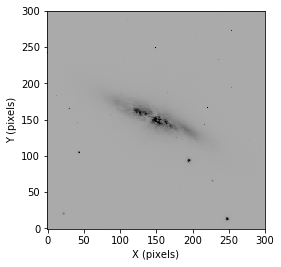

In [29]:
ax = plt.subplot()
ax.imshow(m82_image, cmap='gray_r', origin='lower', vmin=-10, vmax=20)
ax.set_xlabel('X (pixels)')
ax.set_ylabel('Y (pixels)')

Plot the in RA and Declination coordinates space, instead of pixels. The WCS (or World Coordinates System) in a FITS file has a set of keywords that define the coordinate system.  

Typical keywords are the following:

CRVAL1, CRVAL2 - RA and Declination (in degrees) coordinates of CRPIX1 and CRPIX2.

CRPIX1, CRPIX2 - Pixel positions of CRVAL1 and CRVAL2.

CDELT1, CDELT2 - pixel scale (or plate scale) in degrees/pixel 
(or CD matrix: CD1_1, CD1_2, CD2_1, CD2_2 which represent the pixel scale and rotation with respect to the position angle)

In [ ]:
from astropy.wcs import WCS

Use the FITS header to define the WCS of the image.

In [ ]:
head = pf[ext].header
wcs = WCS(head)

ax = plt.subplot(projection=wcs)
ax.imshow(m82_image, cmap='gray_r', origin='lower', vmin=-10, vmax=20)
#ax.grid(color='white', ls='solid')
ax.set_xlabel('Right Ascension (J2000)')
ax.set_ylabel('Declination (J2000)')

#ax.scatter(xid['ra'],xid['dec'],marker="o",s=50,transform=ax.get_transform('fk5'),edgecolor='b', facecolor='none')

## More...

## Resources

http://learn.astropy.org/tutorials.html - list of all the Astropy tutorials

https://docs.astropy.org/en/stable/wcs/ - Astropy WCS implementation

https://docs.astropy.org/en/stable/table/ - Astropy data tables

https://astroquery.readthedocs.io - astroquery documentation

https://photutils.readthedocs.io - photutils documentation